In [1]:
import torch.distributions as dist
import torch
from beanmachine.ppl.model.statistical_model import StatisticalModel
import numpy as np

StatisticalModel.reset()
torch.autograd.set_detect_anomaly(False) 

np.random.seed(4)
torch.manual_seed(4)

In [2]:
# Copyright(C) Facebook, Inc. and its affiliates. All Rights Reserved.
import time
from typing import Dict

import beanmachine.ppl as bm
import pandas as pd
import torch
import torch.distributions as dist
from beanmachine.ppl.experimental.inference_compilation.ic_infer import ICInference
from beanmachine.ppl.model.statistical_model import RVIdentifier
from torch import Tensor, tensor
import torch.optim as optim

from pplbench.PPLBench import PPLBenchPPL


class NSchoolsVectorizedModel:
    def __init__(
        self,
        df,
        num_samples: int,
        num_districts: int,
        num_states: int,
        num_types: int,
        inference_type: str,
        sd_district_scale: float = 1,
        sd_state_scale: float = 1,
        sd_type_scale: float = 1,
        num_worlds: int = 100,
        batch_size: int = 16,
        node_id_embedding_dim: int = 0,
        node_embedding_dim: int = 32,
        mb_embedding_dim: int = 32,
        mb_num_layers: int = 3,
        node_proposal_num_layers: int = 1,
        lr: float = 1e-4,
        gmm_num_components: int = 1,
        wd: float = 1e-5,
    ):
        self._df = df
        self._num_samples = num_samples
        self._sd_district_scale = sd_district_scale
        self._sd_state_scale = sd_state_scale
        self._sd_type_scale = sd_type_scale
        super().__init__()

        self._u_sizes = [num_districts * num_states, num_states, num_types]
        self.num_levels = len(self._u_sizes)
        self.torch_re_maps = []
        for i in range(self.num_levels):
            re_map_i = torch.zeros((self._df.shape[0], self._u_sizes[i]))
            for j in range(self._df.shape[0]):
                if i == 0:
                    # beta_district
                    re_map_i[
                        j,
                        self._df.state[j] * self._df.district[j] + self._df.district[j],
                    ] = 1
                elif i == 1:
                    # beta_state
                    re_map_i[j, self._df.state[j]] = 1
                elif i == 2:
                    # beta_type
                    re_map_i[j, self._df.type[j]] = 1
                else:
                    raise Exception("Should not occur.")
            self.torch_re_maps.append(re_map_i)

        self.queries = [self.beta_0()]
        for i in range(self.num_levels):
            self.queries += [self.sds(i), self.u(i)]
        self.observations: Dict[RVIdentifier, Tensor] = {
            self.y(): tensor(self._df.yi).float()
        }

        self.inference_type = inference_type
        if self.inference_type == "ic":
            self._icmh = ICInference()
            self._icmh.compile(
                observation_keys=list(self.observations.keys()),
                num_worlds=num_worlds,
                batch_size=batch_size,
                node_id_embedding_dim=node_id_embedding_dim,
                node_embedding_dim=node_embedding_dim,
                mb_embedding_dim=mb_embedding_dim,
                mb_num_layers=mb_num_layers,
                node_proposal_num_layers=node_proposal_num_layers,
                optimizer_func=lambda x: optim.Adam(x, lr=lr, weight_decay=wd),
                gmm_num_components=gmm_num_components,
            )

    @bm.random_variable
    def beta_0(self):
        return dist.StudentT(3, loc=0.0, scale=10.0)

    @bm.random_variable
    def sds(self, i):
        assert i < self.num_levels
        return dist.HalfCauchy(
            [self._sd_district_scale, self._sd_state_scale, self._sd_type_scale][i]
        )

    @bm.random_variable
    def u(self, i):
        assert i < self.num_levels
        return dist.Independent(
            dist.Normal(torch.zeros(self._u_sizes[i]), self.sds(i).item()), 1
        )

    @bm.random_variable
    def y(self):
        yhat = self.beta_0() + sum(
            torch.mm(self.torch_re_maps[i], self.u(i).reshape(self._u_sizes[i], 1))
            for i in range(self.num_levels)
        )
        yhat = yhat.reshape(-1)
        return dist.Independent(dist.Normal(yhat, tensor(self._df.sei).float()), 1)

    def infer(self, num_adaptive_samples=0):
        if self.inference_type == "mcmc":
            return bm.CompositionalInference().infer(
                self.queries,
                self.observations,
                num_samples=int(self._num_samples),
                num_chains=1,
                num_adaptive_samples=int(num_adaptive_samples),
            )
        elif self.inference_type == "mcmc-uniform":
            return bm.SingleSiteUniformMetropolisHastings().infer(
                self.queries,
                self.observations,
                num_samples=int(self._num_samples),
                num_chains=1,
                num_adaptive_samples=int(num_adaptive_samples),
            )
        elif self.inference_type == "mcmc-rw":
            return bm.SingleSiteRandomWalk().infer(
                self.queries,
                self.observations,
                num_samples=int(self._num_samples),
                num_chains=1,
                num_adaptive_samples=int(num_adaptive_samples),
            )
        elif self.inference_type == "mcmc-hmc":
            return bm.SingleSiteHamiltonianMonteCarlo(path_length=10, step_size=0.1).infer(
                self.queries,
                self.observations,
                num_samples=int(self._num_samples),
                num_chains=1,
                num_adaptive_samples=int(num_adaptive_samples),
            )
        elif self.inference_type == "ic":
            return self._icmh.infer(
                self.queries,
                self.observations,
                num_samples=int(self._num_samples),
                num_chains=1,
                num_adaptive_samples=int(num_adaptive_samples),
            )


class NSchoolsVectorized(PPLBenchPPL):
    def obtain_posterior(self, data_train, args_dict: Dict, model):
        """
        Beanmachine vectorized implementation of n-schools.

        :param data_train:
        :param args_dict: a dict of model arguments
        :returns: samples_beanmachine(dict): posterior samples of all parameters
        :returns: timing_info(dict): compile_time, inference_time
        """
        num_samples = args_dict["num_samples_beanmachine_vectorized"]
        num_states, num_districts, num_types = [int(x) for x in args_dict["model_args"]]

        compile_start = time.time()
        model = NSchoolsVectorizedModel(
            data_train,
            inference_type=args_dict["inference_type"],
            num_samples=num_samples,
            num_districts=num_districts,
            num_states=num_states,
            num_types=num_types,
        )
        elapsed_time_compile_beanmachine = time.time() - compile_start

        inference_start = time.time()
        samples = model.infer().get_chain()
        elapsed_time_inference_beanmachine = time.time() - inference_start

        timing_info = {
            "compile_time": elapsed_time_compile_beanmachine,
            "inference_time": elapsed_time_inference_beanmachine,
        }

        samples_formatted = pd.DataFrame()
        samples_formatted["beta_0"] = samples.get_variable(model.beta_0())
        for i, level in enumerate(["district", "state", "type"]):
            samples_formatted[f"sd_{level}"] = samples.get_variable(model.sds(i))

            u_i = samples.get_variable(model.u(i))
            for j in range(model._u_sizes[i]):
                if level == "district":
                    state = int(j / num_districts)
                    district = j % num_districts
                    samples_formatted[f"beta_state_{state}_district_{district}"] = u_i[
                        :, j
                    ]
                else:
                    samples_formatted[f"beta_{level}_{j}"] = u_i[:, j]

        return (samples_formatted, timing_info)


In [3]:
timing_infos = {}
posterior_samples = {}
posterior_predictive = {}

In [4]:
import time
import numpy as np
import pandas as pd

import pplbench.models.n_schools_model as model

_model = model

args_dict = model.get_defaults()
args_dict["trials"] = 10
args_dict["plot_data_size"] = 100
args_dict["inference_type"] = "mcmc"
args_dict["num_samples"] = 100
args_dict["num_samples_beanmachine_vectorized"] = 100

model_instance = model.generate_model(args_dict)
generated_data = model.generate_data(args_dict=args_dict, model=model_instance)
ppl_instance = NSchoolsVectorized()


ppl = 'BM_NMC'
timing_infos[ppl] = [None] * int(args_dict["trials"])
posterior_samples[ppl] = [None] * int(args_dict["trials"])
posterior_predictive[ppl] = [None] * int(args_dict["trials"])
ic = None
# start trial loop
for i in range(int(args_dict["trials"])):
    print("Starting trial", i + 1, "of", args_dict["trials"])
    
    # obtain posterior samples and timing info
    data_train=generated_data["data_train"]
    num_samples = args_dict["num_samples_beanmachine_vectorized"]
    num_states, num_districts, num_types = [int(x) for x in args_dict["model_args"]]

    compile_start = time.time()
    model = NSchoolsVectorizedModel(
        data_train,
        inference_type=args_dict["inference_type"],
        num_samples=num_samples,
        num_districts=num_districts,
        num_states=num_states,
        num_types=num_types,
        num_worlds=1e3,
        gmm_num_components=10,
        node_embedding_dim=32,
        mb_embedding_dim=32,
        batch_size=1,
        lr=1e-4,
        wd=1e-5,
    )
    elapsed_time_compile_beanmachine = time.time() - compile_start

    inference_start = time.time()
    samples = model.infer(
        num_adaptive_samples=int(0),
#         num_adaptive_samples=int(1e3),
    ).get_chain()
    elapsed_time_inference_beanmachine = time.time() - inference_start

    timing_info = {
        "compile_time": elapsed_time_compile_beanmachine,
        "inference_time": elapsed_time_inference_beanmachine,
    }

    samples_formatted = pd.DataFrame()
    samples_formatted["beta_0"] = samples.get_variable(model.beta_0())
    for _i, level in enumerate(["district", "state", "type"]):
        samples_formatted[f"sd_{level}"] = samples.get_variable(model.sds(_i))

        u_i = samples.get_variable(model.u(_i))
        for j in range(model._u_sizes[_i]):
            if level == "district":
                state = int(j / num_districts)
                district = j % num_districts
                samples_formatted[f"beta_state_{state}_district_{district}"] = u_i[
                    :, j
                ]
            else:
                samples_formatted[f"beta_{level}_{j}"] = u_i[:, j]
    
    (
        posterior_samples[ppl][i],
        timing_infos[ppl][i],
    ) = samples_formatted, timing_info
    
    model = _model
    
    # compute posterior predictive
    posterior_predictive[ppl][i] = model.evaluate_posterior_predictive(
        samples=posterior_samples[ppl][i].copy(),
        data_test=generated_data["data_test"],
        model=model_instance,
    )
    print(
        f"Trial {i + 1} "
        f'complete in {timing_infos[ppl][i]["inference_time"]} '
        "seconds.\n Statistics of  posterior predictive\n mean:"
        f"{np.array(posterior_predictive[ppl][i]).mean()}"
        f"\n var: {np.array(posterior_predictive[ppl][i]).var()}"
    )

Generating data
Starting trial 1 of 10



Trial 1 complete in 25.89471411705017 seconds.
 Statistics of  posterior predictive
 mean:1.6549675159724442
 var: 3.840382696729695
Starting trial 2 of 10



Trial 2 complete in 27.488704681396484 seconds.
 Statistics of  posterior predictive
 mean:1.369258190331271
 var: 3.9536218182431124
Starting trial 3 of 10



Trial 3 complete in 26.41641616821289 seconds.
 Statistics of  posterior predictive
 mean:4.2146348015536015
 var: 0.09758247216963488
Starting trial 4 of 10



Trial 4 complete in 25.72386074066162 seconds.
 Statistics of  posterior predictive
 mean:1.2086750870725533
 var: 4.649918797756915
Starting trial 5 of 10



Trial 5 complete in 25.918257474899292 seconds.
 Statistics of  posterior predictive
 mean:0.6664457731107885
 var: 7.380085977737382
Starting trial 6 of 10



Trial 6 complete in 26.119300365447998 seconds.
 Statistics of  posterior predictive
 mean:4.1382164848654615
 var: 0.10249847498970467
Starting trial 7 of 10



Trial 7 complete in 26.90136694908142 seconds.
 Statistics of  posterior predictive
 mean:1.2683073540031626
 var: 3.9785706742747915
Starting trial 8 of 10



Trial 8 complete in 28.245262145996094 seconds.
 Statistics of  posterior predictive
 mean:1.9539809598210391
 var: 2.338401381274374
Starting trial 9 of 10



Trial 9 complete in 26.83334493637085 seconds.
 Statistics of  posterior predictive
 mean:2.71434240538543
 var: 0.7865701106781134
Starting trial 10 of 10



Trial 10 complete in 26.234057664871216 seconds.
 Statistics of  posterior predictive
 mean:1.0860324985596583
 var: 6.055957818884829


In [5]:
import time
import numpy as np
import pandas as pd

import pplbench.models.n_schools_model as model

_model = model

args_dict = model.get_defaults()
args_dict["trials"] = 10
args_dict["plot_data_size"] = 100
args_dict["inference_type"] = "mcmc-uniform"
args_dict["num_samples"] = 100
args_dict["num_samples_beanmachine_vectorized"] = 100

ppl = 'BM_uniform'
timing_infos[ppl] = [None] * int(args_dict["trials"])
posterior_samples[ppl] = [None] * int(args_dict["trials"])
posterior_predictive[ppl] = [None] * int(args_dict["trials"])
ic = None
# start trial loop
for i in range(int(args_dict["trials"])):
    print("Starting trial", i + 1, "of", args_dict["trials"])
    
    # obtain posterior samples and timing info
    data_train=generated_data["data_train"]
    num_samples = args_dict["num_samples_beanmachine_vectorized"]
    num_states, num_districts, num_types = [int(x) for x in args_dict["model_args"]]

    compile_start = time.time()
    model = NSchoolsVectorizedModel(
        data_train,
        inference_type=args_dict["inference_type"],
        num_samples=num_samples,
        num_districts=num_districts,
        num_states=num_states,
        num_types=num_types,
        num_worlds=1e3,
        gmm_num_components=10,
        node_embedding_dim=32,
        mb_embedding_dim=32,
        batch_size=1,
        lr=1e-4,
        wd=1e-5,
    )
    elapsed_time_compile_beanmachine = time.time() - compile_start

    inference_start = time.time()
    samples = model.infer(
        num_adaptive_samples=int(0),
#         num_adaptive_samples=int(1e3),
    ).get_chain()
    elapsed_time_inference_beanmachine = time.time() - inference_start

    timing_info = {
        "compile_time": elapsed_time_compile_beanmachine,
        "inference_time": elapsed_time_inference_beanmachine,
    }

    samples_formatted = pd.DataFrame()
    samples_formatted["beta_0"] = samples.get_variable(model.beta_0())
    for _i, level in enumerate(["district", "state", "type"]):
        samples_formatted[f"sd_{level}"] = samples.get_variable(model.sds(_i))

        u_i = samples.get_variable(model.u(_i))
        for j in range(model._u_sizes[_i]):
            if level == "district":
                state = int(j / num_districts)
                district = j % num_districts
                samples_formatted[f"beta_state_{state}_district_{district}"] = u_i[
                    :, j
                ]
            else:
                samples_formatted[f"beta_{level}_{j}"] = u_i[:, j]
    
    (
        posterior_samples[ppl][i],
        timing_infos[ppl][i],
    ) = samples_formatted, timing_info
    
    model = _model
    
    # compute posterior predictive
    posterior_predictive[ppl][i] = model.evaluate_posterior_predictive(
        samples=posterior_samples[ppl][i].copy(),
        data_test=generated_data["data_test"],
        model=model_instance,
    )
    print(
        f"Trial {i + 1} "
        f'complete in {timing_infos[ppl][i]["inference_time"]} '
        "seconds.\n Statistics of  posterior predictive\n mean:"
        f"{np.array(posterior_predictive[ppl][i]).mean()}"
        f"\n var: {np.array(posterior_predictive[ppl][i]).var()}"
    )

Starting trial 1 of 10



Trial 1 complete in 22.29210090637207 seconds.
 Statistics of  posterior predictive
 mean:-30.7333423439083
 var: 119.9547044113631
Starting trial 2 of 10



Trial 2 complete in 22.86727285385132 seconds.
 Statistics of  posterior predictive
 mean:-14.37076373485502
 var: 46.946032159136706
Starting trial 3 of 10



Trial 3 complete in 22.342613220214844 seconds.
 Statistics of  posterior predictive
 mean:-15.665518786761446
 var: 184.6062371557077
Starting trial 4 of 10



Trial 4 complete in 22.19943404197693 seconds.
 Statistics of  posterior predictive
 mean:-22.165564064261094
 var: 44.100984557554554
Starting trial 5 of 10



Trial 5 complete in 21.455495595932007 seconds.
 Statistics of  posterior predictive
 mean:-34.81737427719633
 var: 329.164941246067
Starting trial 6 of 10



Trial 6 complete in 22.522618293762207 seconds.
 Statistics of  posterior predictive
 mean:-22.461130482373488
 var: 31.359946902870316
Starting trial 7 of 10



Trial 7 complete in 21.94502854347229 seconds.
 Statistics of  posterior predictive
 mean:-31.362475716209072
 var: 114.2222738961922
Starting trial 8 of 10



Trial 8 complete in 22.913940906524658 seconds.
 Statistics of  posterior predictive
 mean:-17.793349845400733
 var: 11.535964814356038
Starting trial 9 of 10



Trial 9 complete in 21.63244128227234 seconds.
 Statistics of  posterior predictive
 mean:-25.99566608347975
 var: 172.66448853081914
Starting trial 10 of 10



Trial 10 complete in 21.70352792739868 seconds.
 Statistics of  posterior predictive
 mean:-22.153811724456283
 var: 34.46041499811062


In [6]:
# import time
# import numpy as np
# import pandas as pd

# import pplbench.models.n_schools_model as model

# _model = model

# args_dict = model.get_defaults()
# args_dict["trials"] = 5
# args_dict["plot_data_size"] = 100
# args_dict["inference_type"] = "mcmc-hmc"
# args_dict["num_samples"] = 100
# args_dict["num_samples_beanmachine_vectorized"] = 100

# model_instance = model.generate_model(args_dict)
# generated_data = model.generate_data(args_dict=args_dict, model=model_instance)
# ppl_instance = NSchoolsVectorized()


# ppl = 'BM_hmc'
# timing_infos[ppl] = [None] * int(args_dict["trials"])
# posterior_samples[ppl] = [None] * int(args_dict["trials"])
# posterior_predictive[ppl] = [None] * int(args_dict["trials"])
# ic = None
# # start trial loop
# for i in range(int(args_dict["trials"])):
#     print("Starting trial", i + 1, "of", args_dict["trials"])
    
#     # obtain posterior samples and timing info
#     data_train=generated_data["data_train"]
#     num_samples = args_dict["num_samples_beanmachine_vectorized"]
#     num_states, num_districts, num_types = [int(x) for x in args_dict["model_args"]]

#     compile_start = time.time()
#     model = NSchoolsVectorizedModel(
#         data_train,
#         inference_type=args_dict["inference_type"],
#         num_samples=num_samples,
#         num_districts=num_districts,
#         num_states=num_states,
#         num_types=num_types,
#         num_worlds=1e3,
#         gmm_num_components=10,
#         node_embedding_dim=32,
#         mb_embedding_dim=32,
#         batch_size=1,
#         lr=1e-4,
#         wd=1e-5,
#     )
#     elapsed_time_compile_beanmachine = time.time() - compile_start

#     inference_start = time.time()
#     samples = model.infer(
#         num_adaptive_samples=int(0),
# #         num_adaptive_samples=int(1e3),
#     ).get_chain()
#     elapsed_time_inference_beanmachine = time.time() - inference_start

#     timing_info = {
#         "compile_time": elapsed_time_compile_beanmachine,
#         "inference_time": elapsed_time_inference_beanmachine,
#     }

#     samples_formatted = pd.DataFrame()
#     samples_formatted["beta_0"] = samples.get_variable(model.beta_0())
#     for _i, level in enumerate(["district", "state", "type"]):
#         samples_formatted[f"sd_{level}"] = samples.get_variable(model.sds(_i))

#         u_i = samples.get_variable(model.u(_i))
#         for j in range(model._u_sizes[_i]):
#             if level == "district":
#                 state = int(j / num_districts)
#                 district = j % num_districts
#                 samples_formatted[f"beta_state_{state}_district_{district}"] = u_i[
#                     :, j
#                 ]
#             else:
#                 samples_formatted[f"beta_{level}_{j}"] = u_i[:, j]
    
#     (
#         posterior_samples[ppl][i],
#         timing_infos[ppl][i],
#     ) = samples_formatted, timing_info
    
#     model = _model
    
#     # compute posterior predictive
#     posterior_predictive[ppl][i] = model.evaluate_posterior_predictive(
#         samples=posterior_samples[ppl][i].copy(),
#         data_test=generated_data["data_test"],
#         model=model_instance,
#     )
#     print(
#         f"Trial {i + 1} "
#         f'complete in {timing_infos[ppl][i]["inference_time"]} '
#         "seconds.\n Statistics of  posterior predictive\n mean:"
#         f"{np.array(posterior_predictive[ppl][i]).mean()}"
#         f"\n var: {np.array(posterior_predictive[ppl][i]).var()}"
#     )

In [7]:
import time
import numpy as np
import pandas as pd

import pplbench.models.n_schools_model as model

_model = model

args_dict = model.get_defaults()
args_dict["trials"] = 10
args_dict["plot_data_size"] = 100
args_dict["inference_type"] = "mcmc-rw"
args_dict["num_samples"] = 100
args_dict["num_samples_beanmachine_vectorized"] = 100


ppl = 'BM_RW'
timing_infos[ppl] = [None] * int(args_dict["trials"])
posterior_samples[ppl] = [None] * int(args_dict["trials"])
posterior_predictive[ppl] = [None] * int(args_dict["trials"])
ic = None
# start trial loop
for i in range(int(args_dict["trials"])):
    print("Starting trial", i + 1, "of", args_dict["trials"])
    
    # obtain posterior samples and timing info
    data_train=generated_data["data_train"]
    num_samples = args_dict["num_samples_beanmachine_vectorized"]
    num_states, num_districts, num_types = [int(x) for x in args_dict["model_args"]]

    compile_start = time.time()
    model = NSchoolsVectorizedModel(
        data_train,
        inference_type=args_dict["inference_type"],
        num_samples=num_samples,
        num_districts=num_districts,
        num_states=num_states,
        num_types=num_types,
        num_worlds=1e3,
        gmm_num_components=10,
        node_embedding_dim=32,
        mb_embedding_dim=32,
        batch_size=1,
        lr=1e-4,
        wd=1e-5,
    )
    elapsed_time_compile_beanmachine = time.time() - compile_start

    inference_start = time.time()
    samples = model.infer(
        num_adaptive_samples=int(0),
#         num_adaptive_samples=int(1e3),
    ).get_chain()
    elapsed_time_inference_beanmachine = time.time() - inference_start

    timing_info = {
        "compile_time": elapsed_time_compile_beanmachine,
        "inference_time": elapsed_time_inference_beanmachine,
    }

    samples_formatted = pd.DataFrame()
    samples_formatted["beta_0"] = samples.get_variable(model.beta_0())
    for _i, level in enumerate(["district", "state", "type"]):
        samples_formatted[f"sd_{level}"] = samples.get_variable(model.sds(_i))

        u_i = samples.get_variable(model.u(_i))
        for j in range(model._u_sizes[_i]):
            if level == "district":
                state = int(j / num_districts)
                district = j % num_districts
                samples_formatted[f"beta_state_{state}_district_{district}"] = u_i[
                    :, j
                ]
            else:
                samples_formatted[f"beta_{level}_{j}"] = u_i[:, j]
    
    (
        posterior_samples[ppl][i],
        timing_infos[ppl][i],
    ) = samples_formatted, timing_info
    
    model = _model
    
    # compute posterior predictive
    posterior_predictive[ppl][i] = model.evaluate_posterior_predictive(
        samples=posterior_samples[ppl][i].copy(),
        data_test=generated_data["data_test"],
        model=model_instance,
    )
    print(
        f"Trial {i + 1} "
        f'complete in {timing_infos[ppl][i]["inference_time"]} '
        "seconds.\n Statistics of  posterior predictive\n mean:"
        f"{np.array(posterior_predictive[ppl][i]).mean()}"
        f"\n var: {np.array(posterior_predictive[ppl][i]).var()}"
    )

Starting trial 1 of 10



Trial 1 complete in 21.714799642562866 seconds.
 Statistics of  posterior predictive
 mean:2.042910095745667
 var: 4.666072126936848
Starting trial 2 of 10



Trial 2 complete in 23.548874855041504 seconds.
 Statistics of  posterior predictive
 mean:2.8653711302244154
 var: 2.6024231978180996
Starting trial 3 of 10



Trial 3 complete in 25.295844554901123 seconds.
 Statistics of  posterior predictive
 mean:3.0621577727716254
 var: 0.8912370103594579
Starting trial 4 of 10



Trial 4 complete in 24.5461745262146 seconds.
 Statistics of  posterior predictive
 mean:3.1853845945760657
 var: 0.1666850285046411
Starting trial 5 of 10



Trial 5 complete in 24.86508846282959 seconds.
 Statistics of  posterior predictive
 mean:1.725474115354107
 var: 4.3928568736407865
Starting trial 6 of 10



Trial 6 complete in 23.369320392608643 seconds.
 Statistics of  posterior predictive
 mean:1.1506635702950765
 var: 9.643470619254574
Starting trial 7 of 10



Trial 7 complete in 22.20425820350647 seconds.
 Statistics of  posterior predictive
 mean:-5.410391234973113
 var: 27.731857361229707
Starting trial 8 of 10



Trial 8 complete in 23.319977283477783 seconds.
 Statistics of  posterior predictive
 mean:3.2647257679136628
 var: 0.4722787500270838
Starting trial 9 of 10



Trial 9 complete in 22.228455781936646 seconds.
 Statistics of  posterior predictive
 mean:0.8157129925901973
 var: 6.089538412899258
Starting trial 10 of 10



Trial 10 complete in 22.735130310058594 seconds.
 Statistics of  posterior predictive
 mean:1.5045350278669625
 var: 7.541933767876494


In [8]:
import time
import numpy as np
import pandas as pd

import pplbench.models.n_schools_model as model


_model = model

args_dict = model.get_defaults()
args_dict["trials"] = 10
args_dict["plot_data_size"] = 100
args_dict["inference_type"] = "ic"
args_dict["num_samples"] = 100
args_dict["num_samples_beanmachine_vectorized"] = 100

ppl = 'BM_IC'
timing_infos[ppl] = [None] * int(args_dict["trials"])
posterior_samples[ppl] = [None] * int(args_dict["trials"])
posterior_predictive[ppl] = [None] * int(args_dict["trials"])
ic = None
# start trial loop
for i in range(int(args_dict["trials"])):
    print("Starting trial", i + 1, "of", args_dict["trials"])
    
    # obtain posterior samples and timing info
    data_train=generated_data["data_train"]
    num_samples = args_dict["num_samples_beanmachine_vectorized"]
    num_states, num_districts, num_types = [int(x) for x in args_dict["model_args"]]

    compile_start = time.time()
    model = NSchoolsVectorizedModel(
        data_train,
        inference_type=args_dict["inference_type"],
        num_samples=num_samples,
        num_districts=num_districts,
        num_states=num_states,
        num_types=num_types,
        num_worlds=1e3,
        gmm_num_components=10,
        node_embedding_dim=32,
        mb_embedding_dim=32,
        batch_size=1,
        lr=1e-5,
        wd=1e-6,
    )
    elapsed_time_compile_beanmachine = time.time() - compile_start

    inference_start = time.time()
    samples = model.infer(
        num_adaptive_samples=int(0),
#         num_adaptive_samples=int(1e3),
    ).get_chain()
    elapsed_time_inference_beanmachine = time.time() - inference_start

    timing_info = {
        "compile_time": elapsed_time_compile_beanmachine,
        "inference_time": elapsed_time_inference_beanmachine,
    }

    samples_formatted = pd.DataFrame()
    samples_formatted["beta_0"] = samples.get_variable(model.beta_0())
    for _i, level in enumerate(["district", "state", "type"]):
        samples_formatted[f"sd_{level}"] = samples.get_variable(model.sds(_i))

        u_i = samples.get_variable(model.u(_i))
        for j in range(model._u_sizes[_i]):
            if level == "district":
                state = int(j / num_districts)
                district = j % num_districts
                samples_formatted[f"beta_state_{state}_district_{district}"] = u_i[
                    :, j
                ]
            else:
                samples_formatted[f"beta_{level}_{j}"] = u_i[:, j]
    
    (
        posterior_samples[ppl][i],
        timing_infos[ppl][i],
    ) = samples_formatted, timing_info
    
    model = _model
    
    # compute posterior predictive
    posterior_predictive[ppl][i] = model.evaluate_posterior_predictive(
        samples=posterior_samples[ppl][i].copy(),
        data_test=generated_data["data_test"],
        model=model_instance,
    )
    print(
        f"Trial {i + 1} "
        f'complete in {timing_infos[ppl][i]["inference_time"]} '
        "seconds.\n Statistics of  posterior predictive\n mean:"
        f"{np.array(posterior_predictive[ppl][i]).mean()}"
        f"\n var: {np.array(posterior_predictive[ppl][i]).var()}"
    )

Starting trial 1 of 10


Loss: tensor([30.4036], grad_fn=<AddBackward0>))))))



Trial 1 complete in 24.161322593688965 seconds.
 Statistics of  posterior predictive
 mean:3.7139228003780573
 var: 1.4678177981745404
Starting trial 2 of 10


Loss: tensor([13.7712], grad_fn=<AddBackward0>))>)))



Trial 2 complete in 26.792700052261353 seconds.
 Statistics of  posterior predictive
 mean:-8.264353308135682
 var: 31.728110681488605
Starting trial 3 of 10


Loss: tensor([30.0185], grad_fn=<AddBackward0>))))))



Trial 3 complete in 24.847769021987915 seconds.
 Statistics of  posterior predictive
 mean:3.3203719655585426
 var: 1.713240123861237
Starting trial 4 of 10


Loss: tensor([112.2905], grad_fn=<AddBackward0>)>)>)



Trial 4 complete in 25.0601909160614 seconds.
 Statistics of  posterior predictive
 mean:3.2906050924317687
 var: 0.4660490718053422
Starting trial 5 of 10


Loss: tensor([35.5338], grad_fn=<AddBackward0>))>)))



Trial 5 complete in 24.43287491798401 seconds.
 Statistics of  posterior predictive
 mean:4.745777018405831
 var: 0.13448182063241462
Starting trial 6 of 10


Loss: tensor([104.6121], grad_fn=<AddBackward0>))0>)



Trial 6 complete in 23.683905839920044 seconds.
 Statistics of  posterior predictive
 mean:0.18543061459390572
 var: 8.577311739310653
Starting trial 7 of 10


Loss: tensor([31.3718], grad_fn=<AddBackward0>)0>)>)



Trial 7 complete in 24.49493908882141 seconds.
 Statistics of  posterior predictive
 mean:4.167258833743309
 var: 0.21432956493254246
Starting trial 8 of 10


Loss: tensor([34.3804], grad_fn=<AddBackward0>))>)))



Trial 8 complete in 23.696625471115112 seconds.
 Statistics of  posterior predictive
 mean:2.288248417798044
 var: 0.9383122314636202
Starting trial 9 of 10


Loss: tensor([7.9957], grad_fn=<AddBackward0>)))))>)



Trial 9 complete in 24.05576181411743 seconds.
 Statistics of  posterior predictive
 mean:1.461104321044111
 var: 6.8452788544852865
Starting trial 10 of 10


Loss: tensor([30.5340], grad_fn=<AddBackward0>)0>)))



Trial 10 complete in 24.754242420196533 seconds.
 Statistics of  posterior predictive
 mean:-5.861036530540998
 var: 12.936418263555733


In [9]:
!python -m pplbench.PPLBench -l stan -m n_schools --trials 10

Generating data
Starting benchmark...
Outputs will be saved in : ./outputs/09-10-2020_23:09:33
stan:
Starting trial 1 of 10
INFO:pystan:COMPILING THE C++ CODE FOR MODEL n_schools_8274850a5d1d0bb08670a4967437dbb1 NOW.

Gradient evaluation took 0.000288 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.88 seconds.
Adjust your expectations accordingly!


         three stages of adaptation as currently configured.
         Reducing each adaptation stage to 15%/75%/10% of
         the given number of warmup iterations:
           init_buffer = 7
           adapt_window = 38
           term_buffer = 5

Iteration:  1 / 100 [  1%]  (Warmup)
Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in 'unknown file name' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices,

In [15]:
dataset_dict = {}

In [27]:
from pplbench import PPLBench
import pickle
import arviz as az

del posterior_predictive['NUTS']

posterior_samples_subset = PPLBench.get_sample_subset(posterior_predictive, args_dict)
trial_info = PPLBench.compute_trial_statistics(posterior_predictive)
trial_info = PPLBench.combine_dictionaries(trial_info, timing_infos)
summary_info = PPLBench.compute_summary_statistics(
    posterior_predictive, timing_infos, args_dict
)

#most_recent = './outputs/01-09-2020_01:10:48'
#most_recent = './outputs/01-10-2020_23:07:25'
most_recent = './outputs/09-10-2020_23:09:33'
stan_trials = pd.read_csv(f"{most_recent}/trial_info.csv")

stan_posterior = pd.DataFrame(
    pickle.load(open(f"{most_recent}/posterior_predictives.pkl", "rb"))["stan"]
)
posterior_predictive['NUTS'] = list(stan_posterior.to_numpy())

trials = pickle.load(open(f"{most_recent}/posterior_samples.pkl", "rb"))['stan']
data = {}
for i, chains in enumerate(trials):
    for j, sample in enumerate(chains.to_dict('index').values()):
        for var in sample:
            if var not in data:
                if np.array(sample[var]).size == 1:
                    data[var] = np.zeros((len(trials), len(chains)))
                else:
                    data[var] = np.zeros((len(trials), len(chains), sample[var].shape[1]))
            data[var][i][j] = sample[var]
ppl = 'NUTS'
del data['chain']
del data['draw']
dataset_dict['NUTS'] = az.convert_to_inference_data(data)

In [3]:
import arviz as az
import seaborn as sns
sns.set_style("darkgrid")
sns.set(font_scale=0.7)

from matplotlib import pyplot as plt
plt.rcParams.update({
    "text.usetex": False,
})


for ppl in list(posterior_samples.keys()):
    trials = posterior_samples[ppl]
    
    data = {}
    for i, chains in enumerate(trials):
        for j, sample in enumerate(chains.to_dict('index').values()):
            for var in sample:
                if var not in data:
                    if np.array(sample[var]).ndim == 0:
                        data[var] = np.zeros((len(trials), len(chains)))
                    else:
                        data[var] = np.zeros((len(trials), len(chains), sample[var].shape[0]))
                data[var][i][j] = sample[var]
    dataset_dict[ppl] = az.convert_to_inference_data(data)
    dataset_dict[ppl].log_likelihood = az.dict_to_dataset({
        ppl:posterior_predictive[ppl]
    })

df = pd.DataFrame()
for ppl in list(trial_info.keys()) + ["NUTS"]:
    if ppl == "NUTS":
        trials = stan_trials
    else:
        trials = pd.DataFrame(trial_info[ppl]).T
    trials["ppl"] = ppl
    df = df.append(trials)
    
df = df.sort_values(by='ppl')
df['PLL'] = [
    torch.logsumexp(torch.tensor(x), 0).item()
    for ppl in sorted(posterior_predictive)
    for x in posterior_predictive[ppl]
]
df = df[df['PLL'] > 6] # filter numerical errors
    
# move adaptation to compile time
args_dict["num_adaptive_samples"] = int(1e3)
percent_burn_in = (args_dict["num_adaptive_samples"] / (args_dict["num_samples"] + args_dict["num_adaptive_samples"]))
df["compile_time"][df["ppl"] == "BM_IC"] += df[df["ppl"] == "BM_IC"]["inference_time"] * percent_burn_in
df["inference_time"][df["ppl"] == "BM_IC"] -= df[df["ppl"] == "BM_IC"]["inference_time"] * percent_burn_in
df["efficiency"] = df["n_eff"] / (df["inference_time"])


melted = df.sort_values(by="ppl").melt(
    id_vars=["ppl"],
    value_vars=["compile_time", "inference_time", "PLL"],
)
ppl_replace = {
    'BM_IC': 'LIC',
    'BM_NMC': 'NMC',
    'BM_RW': 'RWMH',
    'BM_uniform': 'Ancestral',
}
melted['ppl'] = melted['ppl'].replace(ppl_replace)
melted['variable'] = melted['variable'].replace({
    'compile_time': 'Compile time (sec)',
    'inference_time': 'Inference time (sec)',
})


NameError: name 'posterior_samples' is not defined

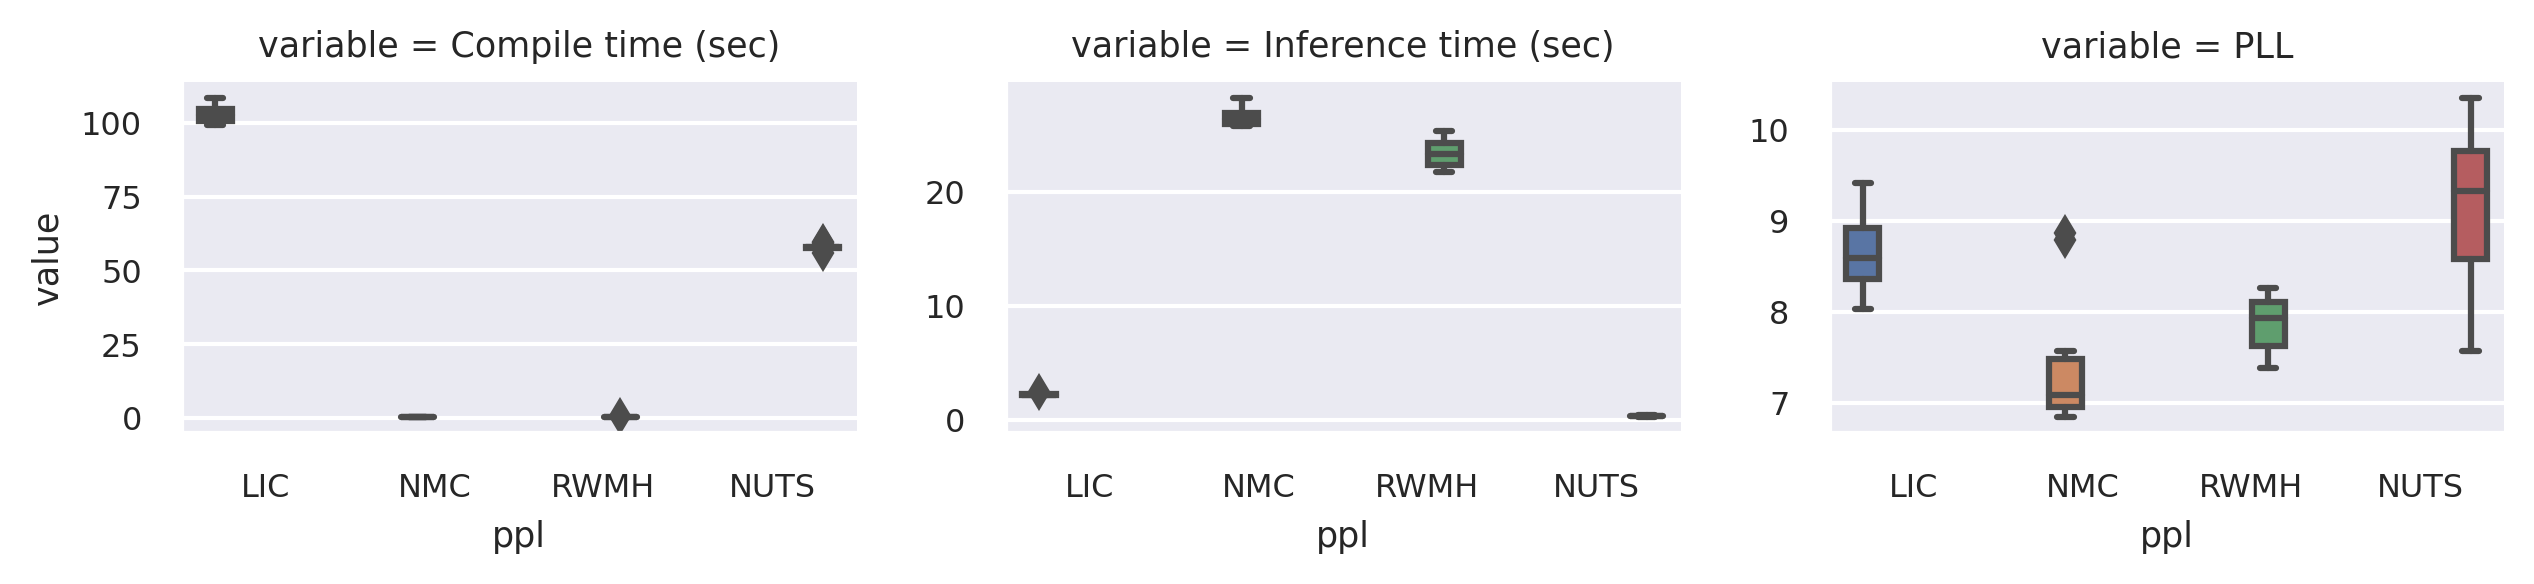

In [5]:
import pickle
#pickle.dump(melted, open("outputs/nschools_pll.pkl", "wb"))
melted = pickle.load(open("outputs/nschools_pll.pkl", "rb"))
melted = melted[melted.ppl != 'Ancestral']
g = sns.catplot(data=melted, col="variable", x="ppl", y="value", hue="ppl", sharey=False, kind="box", col_wrap=3)    


g.fig.set_size_inches(8.5, 2)
g.fig.set_dpi(300)
g.fig.tight_layout()
g.fig.savefig('nschools_pll.pdf', dpi=300)

In [6]:
melted = pd.concat([
    pd.concat([pd.DataFrame({
        'ESS': filter(lambda x: x < 100, az.ess(dataset_dict[ppl]).to_array().values),
        'ppl': ppl
    }) for ppl in sorted(set(df.ppl))]).melt(id_vars=['ppl'], value_vars=['ESS']),
    pd.concat([pd.DataFrame({
        'Rhat': filter(lambda x: x < 7.8, az.rhat(dataset_dict[ppl]).to_array().values),
        'ppl': ppl
    }) for ppl in sorted(set(df.ppl))]).melt(id_vars=['ppl'], value_vars=['Rhat'])
])
melted['ppl'] = melted['ppl'].replace(ppl_replace)


NameError: name 'df' is not defined

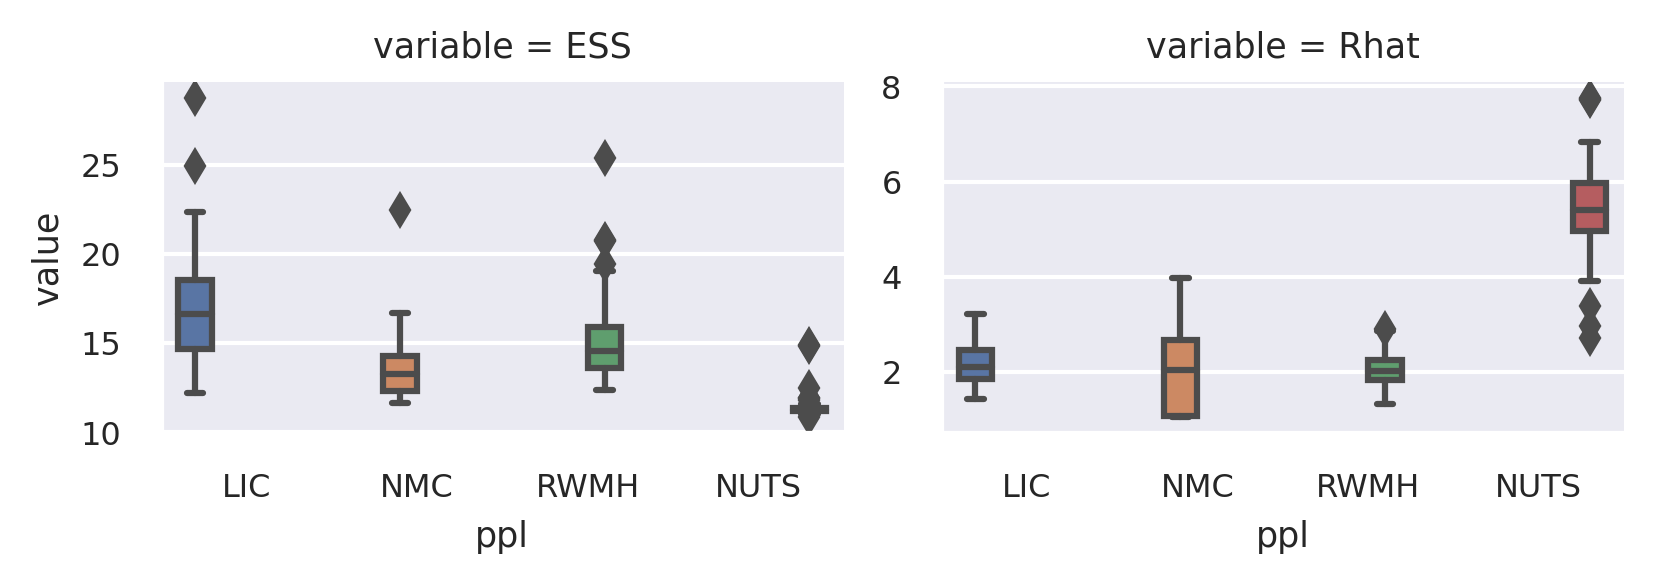

In [7]:
import pickle
#pickle.dump(melted, open("outputs/nschools_ess.pkl", "wb"))
melted = pickle.load(open("outputs/nschools_ess.pkl", "rb"))
melted = melted[melted.ppl != 'Ancestral']
g = sns.catplot(data=melted, col="variable", x="ppl", y="value", hue="ppl", sharey=False, kind="box")    

g.fig.set_size_inches(8.5*2/3, 2)
g.fig.set_dpi(300)
g.fig.tight_layout()
g.fig.savefig('nschools_ess_rhat.pdf', dpi=300)

In [19]:
{
    ppl:float(az.ess(dataset_dict[ppl].posterior.sel(chain=slice(i, i)))["beta_0"])
    for ppl in dataset_dict
    for i in range(args_dict["trials"])
}

{'NUTS': 1.3900781701943397,
 'BM_NMC': 1.683873361770247,
 'BM_uniform': 1.7684748510708936,
 'BM_RW': 7.3529455276740014,
 'BM_IC': 100.08006405124102}

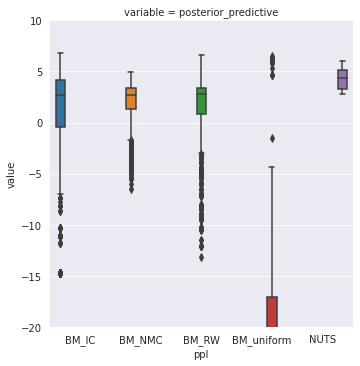

In [21]:
df = pd.DataFrame([
        {
            "ppl": ppl,
            "posterior_predictive": trial_val
        } 
    for ppl in (list(posterior_predictive.keys()) + ["NUTS"])
    for trial in (
        {
            **posterior_predictive,
            **{"NUTS": list(stan_posterior.to_numpy())},
        }[ppl])
    for trial_val in trial
])
f = sns.catplot(data=df.melt(
    id_vars=["ppl"],
    value_vars=["posterior_predictive"],
).sort_values(by="ppl"), col="variable", hue="ppl", x="ppl", y="value", sharey=False, kind="box")
f.set(ylim=(-20,10))

In [22]:
df.melt(
    id_vars=["ppl"],
    value_vars=["posterior_predictive"],
).groupby(["ppl"]).mean()

,value
ppl,
BM_IC,0.904733
BM_NMC,2.027486
BM_RW,1.420654
BM_uniform,-23.751900
NUTS,-inf


In [23]:
import arviz as az
dataset_dict = {}

for ppl in list(posterior_samples.keys()):
    trials = posterior_samples[ppl]
    
    data = {}
    for i, chains in enumerate(trials):
        for j, sample in enumerate(chains):
            for var in sample:
                if var not in data:
                    if sample[var].ndim == 0:
                        data[var] = np.zeros((len(trials), len(chains)))
                    else:
                        data[var] = np.zeros((len(trials), len(chains), sample[var].shape[0]))
                data[var][i][j] = sample[var]
    dataset_dict[ppl] = az.convert_to_inference_data(data)
    dataset_dict[ppl].log_likelihood = az.dict_to_dataset({
        ppl:posterior_predictive[ppl]
    })

TypeError: string indices must be integers